# Regularization
1. Ridge (L2) - Penalty applied on Square of coefficients in loss function
2. Lasso (L1) - Penalty applied on absolue values of coefficients in loss function

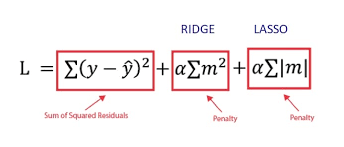

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

# Step 1 - Data Ingestion

In [2]:
import pandas as pd

df = pd.read_csv("Cars93.csv", na_values=["", "NA"], keep_default_na=False)
df.head()

,id,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin,Make
0,1,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,...,5,177,102,68,37,26.5,11.0,2705,non-USA,Acura Integra
1,2,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,...,5,195,115,71,38,30.0,15.0,3560,non-USA,Acura Legend
2,3,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,...,5,180,102,67,37,28.0,14.0,3375,non-USA,Audi 90
3,4,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,...,6,193,106,70,37,31.0,17.0,3405,non-USA,Audi 100
4,5,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,...,4,186,109,69,39,27.0,13.0,3640,non-USA,BMW 535i


# Target - Weight of car

# Step 2 - Perform Basic data quality checks

In [3]:
df.duplicated().sum()

np.int64(1)

In [4]:
df.shape

(94, 28)

In [5]:
df = df.drop_duplicates(keep="first").reset_index(drop=True)
df.shape

(93, 28)

In [7]:
m = df.isna().sum()
m

id                     0
Manufacturer           0
Model                  0
Type                   0
Min.Price              0
Price                  0
Max.Price              0
MPG.city               0
MPG.highway            0
AirBags                4
DriveTrain             0
Cylinders              0
EngineSize             0
Horsepower             0
RPM                    0
Rev.per.mile           0
Man.trans.avail        0
Fuel.tank.capacity     0
Passengers             0
Length                 0
Wheelbase              0
Width                  0
Turn.circle            0
Rear.seat.room         2
Luggage.room          11
Weight                 0
Origin                 0
Make                   0
dtype: int64

In [8]:
m[m > 0]

AirBags            4
Rear.seat.room     2
Luggage.room      11
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  93 non-null     int64  
 1   Manufacturer        93 non-null     object 
 2   Model               93 non-null     object 
 3   Type                93 non-null     object 
 4   Min.Price           93 non-null     float64
 5   Price               93 non-null     float64
 6   Max.Price           93 non-null     float64
 7   MPG.city            93 non-null     int64  
 8   MPG.highway         93 non-null     int64  
 9   AirBags             89 non-null     object 
 10  DriveTrain          93 non-null     object 
 11  Cylinders           93 non-null     object 
 12  EngineSize          93 non-null     float64
 13  Horsepower          93 non-null     int64  
 14  RPM                 93 non-null     int64  
 15  Rev.per.mile        93 non-null     int64  
 16  Man.trans.

# Step 3 - Seperate X and Y(Weight)
and remove unncessary columns

In [10]:
X = df.drop(columns = ["id", "Weight"])
Y = df["Weight"]

In [11]:
X.head()

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make
0,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,Front,...,13.2,5,177,102,68,37,26.5,11.0,non-USA,Acura Integra
1,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,...,18.0,5,195,115,71,38,30.0,15.0,non-USA,Acura Legend
2,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,Front,...,16.9,5,180,102,67,37,28.0,14.0,non-USA,Audi 90
3,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,21.1,6,193,106,70,37,31.0,17.0,non-USA,Audi 100
4,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,...,21.1,4,186,109,69,39,27.0,13.0,non-USA,BMW 535i


In [12]:
X.nunique()

Manufacturer          32
Model                 93
Type                   6
Min.Price             79
Price                 81
Max.Price             79
MPG.city              21
MPG.highway           22
AirBags                3
DriveTrain             3
Cylinders              6
EngineSize            26
Horsepower            57
RPM                   24
Rev.per.mile          78
Man.trans.avail        2
Fuel.tank.capacity    38
Passengers             6
Length                51
Wheelbase             27
Width                 16
Turn.circle           14
Rear.seat.room        24
Luggage.room          16
Origin                 2
Make                  93
dtype: int64

In [13]:
# Remove high cardinality columns
def get_high_cardinality(X: pd.DataFrame, threshold: float = 0.9) -> list[str]:
    unique_count = X.select_dtypes(include="object").nunique()
    cardinality = unique_count / len(X)
    print(cardinality)
    high_cardinality = cardinality[cardinality >=  threshold]
    return high_cardinality.index.tolist()

In [14]:
high_card = get_high_cardinality(X)

Manufacturer       0.344086
Model              1.000000
Type               0.064516
AirBags            0.032258
DriveTrain         0.032258
Cylinders          0.064516
Man.trans.avail    0.021505
Origin             0.021505
Make               1.000000
dtype: float64


In [15]:
high_card

['Model', 'Make']

In [17]:
X = X.drop(columns=high_card)
X.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,...,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
0,Acura,Small,12.9,15.9,18.8,25,31,None,Front,4,...,Yes,13.2,5,177,102,68,37,26.5,11.0,non-USA
1,Acura,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,6,...,Yes,18.0,5,195,115,71,38,30.0,15.0,non-USA
2,Audi,Compact,25.9,29.1,32.3,20,26,Driver only,Front,6,...,Yes,16.9,5,180,102,67,37,28.0,14.0,non-USA
3,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,...,Yes,21.1,6,193,106,70,37,31.0,17.0,non-USA
4,BMW,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,4,...,Yes,21.1,4,186,109,69,39,27.0,13.0,non-USA


# Step 4 - Apply Train test split first

In [18]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    X, Y, test_size=0.3, random_state=10
)

In [19]:
xtrain.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,...,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
2,Audi,Compact,25.9,29.1,32.3,20,26,Driver only,Front,6,...,Yes,16.9,5,180,102,67,37,28.0,14.0,non-USA
58,Mercedes-Benz,Midsize,43.8,61.9,80.0,19,25,Driver & Passenger,Rear,6,...,No,18.5,5,187,110,69,37,27.0,15.0,non-USA
67,Oldsmobile,Compact,13.0,13.5,14.0,24,31,None,Front,4,...,No,15.2,5,188,103,67,39,28.0,14.0,USA
76,Pontiac,Large,19.4,24.4,29.4,19,28,Driver & Passenger,Front,6,...,No,18.0,6,177,111,74,43,30.5,18.0,USA
84,Toyota,Sporty,14.2,18.4,22.6,25,32,Driver only,Front,4,...,Yes,15.9,4,174,99,69,39,23.0,13.0,non-USA


In [20]:
ytrain.head()

2     3375
58    3525
67    2910
76    3495
84    2950
Name: Weight, dtype: int64

In [21]:
xtest.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,...,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
34,Ford,Sporty,12.8,14.0,15.2,24,30,Driver only,Front,4,...,Yes,15.5,4,179,103,70,38,23.0,18.0,USA
90,Volkswagen,Sporty,22.9,23.3,23.7,18,25,None,Front,6,...,Yes,18.5,4,159,97,66,36,26.0,15.0,non-USA
3,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,...,Yes,21.1,6,193,106,70,37,31.0,17.0,non-USA
35,Ford,Van,14.5,19.9,25.3,15,20,Driver only,4WD,6,...,Yes,21.0,7,176,119,72,45,30.0,NaN,USA
19,Chrylser,Large,18.4,18.4,18.4,20,28,Driver & Passenger,Front,6,...,No,18.0,6,203,113,74,40,31.0,15.0,USA


In [22]:
ytest.head()

34    2710
90    2810
3     3405
35    3735
19    3515
Name: Weight, dtype: int64

In [23]:
xtrain.shape

(65, 24)

In [24]:
xtest.shape

(28, 24)

# Step 5 - Apply Preprocessing on X
1. Continuous feature -> SimpleImputer(strategy = "mean") , StandardScaler()
2. Categorical Feature -> SimpleImputer, OrdinalEncoder, Standardscaler

In [26]:
cat = xtrain.select_dtypes(include="object").columns.tolist()
cat

['Manufacturer',
 'Type',
 'AirBags',
 'DriveTrain',
 'Cylinders',
 'Man.trans.avail',
 'Origin']

In [27]:
con = xtrain.select_dtypes(include="number").columns.tolist()
con

['Min.Price',
 'Price',
 'Max.Price',
 'MPG.city',
 'MPG.highway',
 'EngineSize',
 'Horsepower',
 'RPM',
 'Rev.per.mile',
 'Fuel.tank.capacity',
 'Passengers',
 'Length',
 'Wheelbase',
 'Width',
 'Turn.circle',
 'Rear.seat.room',
 'Luggage.room']

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [29]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

In [30]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    StandardScaler()
)

In [31]:
pre = ColumnTransformer(
    [
        ("num", num_pipe, con),
        ("cat", cat_pipe, cat)
    ]
).set_output(transform="pandas")

In [32]:
# Fit the preprocessor on train data
pre.fit(xtrain)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [33]:
# Transform train and test data
xtrain_pre = pre.transform(xtrain)
xtest_pre = pre.transform(xtest)

In [34]:
xtrain_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
2,0.973180,0.918836,0.840807,-0.412420,-0.586550,0.017007,0.448374,0.396313,-0.066228,-0.011249,...,-0.703519,0.046397,0.013226,-1.564922,-1.342107,-0.292449,-0.192961,0.932919,0.765092,1.114172
58,2.971937,4.162683,4.909037,-0.623502,-0.797190,0.385482,1.271144,0.396313,-0.183633,0.476189,...,-0.703519,-0.302943,0.383566,0.391230,-0.147080,-1.754693,1.598822,0.932919,-1.307032,1.114172
67,-0.467264,-0.623969,-0.719961,0.431905,0.466648,-0.443588,0.137550,1.208943,0.129446,-0.529151,...,-0.072778,0.046397,0.013226,0.782461,-1.342107,1.169795,-0.192961,-0.799645,-1.307032,-0.897527
76,0.247375,0.454017,0.593472,-0.623502,-0.165271,0.938195,0.411807,-0.741368,-1.465302,0.323865,...,1.188704,0.919745,1.494585,0.912871,-0.744593,-1.754693,-0.192961,0.932919,-1.307032,-0.897527
84,-0.333269,-0.139370,0.013515,0.642986,0.677288,-0.535706,-0.228125,0.233787,0.178365,-0.315897,...,-0.072778,-1.700300,-0.357113,1.564922,1.047946,-0.292449,-0.192961,-0.799645,0.765092,1.114172


In [35]:
xtest_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
34,-0.489596,-0.574520,-0.617615,0.431905,0.256008,-0.719944,-0.593801,0.396313,0.051176,-0.437756,...,-0.388148,-1.700300,1.494585e+00,-0.521641,1.047946,-0.292449,-0.192961,-0.799645,0.765092,-0.897527
90,0.638193,0.345229,0.107331,-0.834583,-0.797190,0.017007,0.558077,0.883891,0.139230,0.476189,...,-1.018889,-0.652282,3.835661e-01,1.695332,1.047946,1.169795,-0.192961,0.932919,0.765092,1.114172
3,1.520326,1.769357,1.889847,-0.623502,-0.586550,0.017007,0.448374,0.396313,0.432742,1.268274,...,-0.703519,1.094415,1.124245e+00,-1.564922,-0.147080,-0.292449,-0.192961,0.932919,0.765092,1.114172
35,-0.299770,0.008977,0.243792,-1.467826,-1.850388,0.201244,-0.045288,-0.741368,-0.457578,1.237809,...,1.819445,0.745075,-6.578554e-16,-0.521641,1.645460,-0.292449,-1.984744,0.932919,0.765092,-0.897527
19,0.135713,-0.139370,-0.344694,-0.412420,-0.165271,0.477601,0.100983,0.071261,-0.633685,0.323865,...,0.242593,1.094415,3.835661e-01,-1.825742,-0.744593,-1.754693,-0.192961,0.932919,-1.307032,-0.897527


# Step 5 -  Model Building Experiment with different models
1. Baseline - LinearRegression
2. Apply Feature selection - Linear Regression
3. Apply Lasso on Selected features
4. Apply Ridge on selected features

### Model 1 - Baseline Model LinearRegression

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

baseline = LinearRegression()
scores = cross_val_score(baseline, xtrain_pre, ytrain, cv=5, scoring="r2")
scores

array([0.8928423 , 0.92570425, 0.88431367, 0.95944455, 0.87304994])

In [37]:
scores.mean()

np.float64(0.9070709417185455)

In [38]:
scores.std()

np.float64(0.03152133031547317)

In [39]:
# Fit the entire model
baseline.fit(xtrain_pre, ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [40]:
baseline.intercept_

np.float64(3119.999999999998)

In [41]:
baseline.coef_

array([ 3.31205854e+03, -7.57247328e+03,  4.35140974e+03,  3.70953528e+01,
       -1.34782465e+02, -1.20782071e+02,  3.04613391e+02, -1.04887931e+02,
       -5.77770004e+01,  1.05892385e+02,  6.95542111e+00,  3.66115752e+01,
        2.80157989e+02, -5.26075365e+01,  1.79045619e+01, -3.99693198e+01,
        5.39937019e+01,  7.37436832e+00,  4.69993390e+01, -1.57019808e+01,
       -5.72670603e+00,  1.43702833e+01,  3.24813948e+01,  5.92682822e+01])

In [42]:
# R2 score on train
r2_train = baseline.score(xtrain_pre, ytrain)
r2_train

0.9735977057191415

In [43]:
# R2 score on test
r2_test = baseline.score(xtest_pre, ytest)
r2_test

0.8531054380497081

In [44]:
# Generalizaton error
gen_err = r2_train - r2_test
gen_err

0.12049226766943344

### Create a function to save above results for each model

In [51]:
# Intializing a blank results list
results = []

def evaluate_and_log_model(results, model, xtrain, ytrain, xtest, ytest, description):
    # Cross validate data on train
    scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring="r2")
    mean_score = scores.mean().round(4)
    std_score = scores.std().round(4)
    # Fit the model
    model.fit(xtrain, ytrain)
    # Evalutate r2 score on train and test
    r2_train = round(model.score(xtrain, ytrain), 4)
    r2_test = round(model.score(xtest, ytest), 4)
    # Generalization error
    gen_err = round(r2_train - r2_test, 4)
    # Save above results in a dictionary
    r = {
        "description": description,
        "name": type(model).__name__,
        "cv_mean": mean_score,
        "cv_std": std_score,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "gen_err": gen_err
    }
    print(r)
    results.append(r)
    return model

In [52]:
baseline = evaluate_and_log_model(
    results, LinearRegression(), xtrain_pre, ytrain, xtest_pre, ytest,
    description="Baseline LinearRegression"
)

{'description': 'Baseline LinearRegression', 'name': 'LinearRegression', 'cv_mean': np.float64(0.9071), 'cv_std': np.float64(0.0315), 'r2_train': 0.9736, 'r2_test': 0.8531, 'gen_err': 0.1205}


In [53]:
results

[{'description': 'Baseline LinearRegression',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.9071),
  'cv_std': np.float64(0.0315),
  'r2_train': 0.9736,
  'r2_test': 0.8531,
  'gen_err': 0.1205}]

# Model 2 - Feature selection with Linear regression

In [55]:
from sklearn.feature_selection import SequentialFeatureSelector

sel = SequentialFeatureSelector(
    LinearRegression(), n_features_to_select="auto", direction="backward"
)
sel.fit(xtrain_pre, ytrain)

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'backward'
,scoring,None
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [56]:
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Price', 'num__MPG.highway', 'num__EngineSize',
       'num__Horsepower', 'num__RPM', 'num__Fuel.tank.capacity',
       'num__Passengers', 'num__Wheelbase', 'num__Rear.seat.room',
       'num__Luggage.room', 'cat__Type', 'cat__Origin'], dtype=object)

In [58]:
len(sel_cols)

12

In [57]:
xtrain_pre_sel =  sel.transform(xtrain_pre)
xtrain_pre_sel

array([[ 9.18836346e-01, -5.86550440e-01,  1.70065527e-02,
         4.48374418e-01,  3.96313167e-01, -1.12485506e-02,
        -1.80783587e-01, -3.48290386e-01,  4.63966313e-02,
         1.32264167e-02, -1.34210679e+00,  1.11417203e+00],
       [ 4.16268316e+00, -7.97190100e-01,  3.85481861e-01,
         1.27114429e+00,  3.96313167e-01,  4.76188644e-01,
        -1.80783587e-01,  8.83757238e-01, -3.02942710e-01,
         3.83566084e-01, -1.47080196e-01,  1.11417203e+00],
       [-6.23968845e-01,  4.66647864e-01, -4.43587582e-01,
         1.37550245e-01,  1.20894269e+00, -5.29150569e-01,
        -1.80783587e-01, -1.94284433e-01,  4.63966313e-02,
         1.32264167e-02, -1.34210679e+00, -8.97527468e-01],
       [ 4.54016833e-01, -1.65271118e-01,  9.38194823e-01,
         4.11806868e-01, -7.41368165e-01,  3.23864520e-01,
         7.98460843e-01,  1.03776319e+00,  9.19744985e-01,
         1.49458509e+00, -7.44593493e-01, -8.97527468e-01],
       [-1.39369779e-01,  6.77287524e-01, -5.3570640

In [61]:
xtrain_pre_sel.shape

(65, 12)

In [60]:
xtest_pre_sel = sel.transform(xtest_pre)
xtest_pre_sel

array([[-5.74519961e-01,  2.56008203e-01, -7.19944064e-01,
        -5.93800750e-01,  3.96313167e-01, -4.37756096e-01,
        -1.16002802e+00, -1.94284433e-01, -1.70030008e+00,
         1.49458509e+00,  1.04794640e+00, -8.97527468e-01],
       [ 3.45229288e-01, -7.97190100e-01,  1.70065527e-02,
         5.58077067e-01,  8.83890881e-01,  4.76188644e-01,
        -1.16002802e+00, -1.11832015e+00, -6.52282052e-01,
         3.83566084e-01,  1.04794640e+00,  1.11417203e+00],
       [ 1.76935716e+00, -5.86550440e-01,  1.70065527e-02,
         4.48374418e-01,  3.96313167e-01,  1.26827408e+00,
         7.98460843e-01,  2.67733426e-01,  1.09441466e+00,
         1.12424542e+00, -1.47080196e-01,  1.11417203e+00],
       [ 8.97687438e-03, -1.85038840e+00,  2.01244207e-01,
        -4.52875039e-02, -7.41368165e-01,  1.23780926e+00,
         1.77770527e+00,  2.26981082e+00,  7.45075314e-01,
        -6.57855402e-16,  1.64545969e+00, -8.97527468e-01],
       [-1.39369779e-01, -1.65271118e-01,  4.7760068

In [62]:
xtest_pre_sel.shape

(28, 12)

In [63]:
model_feat_sel = evaluate_and_log_model(
    results, LinearRegression(), xtrain_pre_sel, ytrain, xtest_pre_sel, ytest,
    description="Feature Selection on LinearRegression"
)

{'description': 'Feature Selection on LinearRegression', 'name': 'LinearRegression', 'cv_mean': np.float64(0.9455), 'cv_std': np.float64(0.0185), 'r2_train': 0.9701, 'r2_test': 0.8676, 'gen_err': 0.1025}


In [64]:
results

[{'description': 'Baseline LinearRegression',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.9071),
  'cv_std': np.float64(0.0315),
  'r2_train': 0.9736,
  'r2_test': 0.8531,
  'gen_err': 0.1205},
 {'description': 'Feature Selection on LinearRegression',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.9455),
  'cv_std': np.float64(0.0185),
  'r2_train': 0.9701,
  'r2_test': 0.8676,
  'gen_err': 0.1025}]

# Model 3 - Ridge (L2) on selected features

In [66]:
alphas_list = [0.01, 0.1, 1, 10, 50, 100, 500, 1000]

In [67]:
params = {
    "alpha": alphas_list
}
print(params)

{'alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000]}


In [72]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

gscv_ridge = GridSearchCV(Ridge(random_state=42), params, cv=5, scoring="r2")
gscv_ridge.fit(xtrain_pre_sel, ytrain) # Apply this on selected features only

,estimator,Ridge(random_state=42)
,param_grid,"{'alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.1


In [73]:
gscv_ridge.best_params_

{'alpha': 0.1}

In [74]:
gscv_ridge.best_score_

np.float64(0.9459654020956506)

In [75]:
best_ridge = gscv_ridge.best_estimator_
best_ridge

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


In [77]:
sel_ridge = evaluate_and_log_model(
    results, best_ridge, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest,
    description="Ridge on Selected features"
)

{'description': 'Ridge on Selected features', 'name': 'Ridge', 'cv_mean': np.float64(0.946), 'cv_std': np.float64(0.0174), 'r2_train': 0.9701, 'r2_test': 0.8713, 'gen_err': 0.0988}


# Model 4 - Lasso on Selected features

In [78]:
params

{'alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000]}

In [80]:
from sklearn.linear_model import Lasso

gscv_lasso = GridSearchCV(Lasso(random_state=42), params, cv=5, scoring="r2")
gscv_lasso.fit(xtrain_pre_sel, ytrain)

,estimator,Lasso(random_state=42)
,param_grid,"{'alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1


In [82]:
gscv_lasso.best_score_

np.float64(0.9463433605017105)

In [84]:
gscv_lasso.best_params_

{'alpha': 1}

In [85]:
best_lasso = gscv_lasso.best_estimator_
best_lasso

,alpha,1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


In [87]:
sel_lasso = evaluate_and_log_model(
    results, best_lasso, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest,
    description="Lasso on selected features"
)

{'description': 'Lasso on selected features', 'name': 'Lasso', 'cv_mean': np.float64(0.9463), 'cv_std': np.float64(0.0175), 'r2_train': 0.9698, 'r2_test': 0.8812, 'gen_err': 0.0886}


In [88]:
results

[{'description': 'Baseline LinearRegression',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.9071),
  'cv_std': np.float64(0.0315),
  'r2_train': 0.9736,
  'r2_test': 0.8531,
  'gen_err': 0.1205},
 {'description': 'Feature Selection on LinearRegression',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.9455),
  'cv_std': np.float64(0.0185),
  'r2_train': 0.9701,
  'r2_test': 0.8676,
  'gen_err': 0.1025},
 {'description': 'Ridge on Selected features',
  'name': 'Ridge',
  'cv_mean': np.float64(0.946),
  'cv_std': np.float64(0.0174),
  'r2_train': 0.9701,
  'r2_test': 0.8713,
  'gen_err': 0.0988},
 {'description': 'Lasso on selected features',
  'name': 'Lasso',
  'cv_mean': np.float64(0.9463),
  'cv_std': np.float64(0.0175),
  'r2_train': 0.9698,
  'r2_test': 0.8812,
  'gen_err': 0.0886}]

# model 5 - Polynomial feature enginering with Ridge

In [89]:
from sklearn.preprocessing import PolynomialFeatures

In [90]:
poly_ridge = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(random_state=42)
)

In [91]:
params2 = {
    "ridge__alpha": alphas_list
}
params2

{'ridge__alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000]}

In [92]:
gscv_poly_ridge = GridSearchCV(poly_ridge, params2, cv=5, scoring="r2")
gscv_poly_ridge.fit(xtrain_pre_sel, ytrain)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'ridge__alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,2


In [93]:
gscv_poly_ridge.best_params_

{'ridge__alpha': 10}

In [94]:
gscv_poly_ridge.best_score_

np.float64(0.8661633179022112)

In [95]:
best_poly_ridge = gscv_poly_ridge.best_estimator_
best_poly_ridge

,steps,"[('polynomialfeatures', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,alpha,10
,fit_intercept,True
,copy_X,True


In [97]:
sel_poly_ridge = evaluate_and_log_model(
    results, best_poly_ridge, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest,
    description="Polynomial Ridge on Selected Features"
)

{'description': 'Polynomial Ridge on Selected Features', 'name': 'Pipeline', 'cv_mean': np.float64(0.8662), 'cv_std': np.float64(0.0958), 'r2_train': 0.985, 'r2_test': 0.906, 'gen_err': 0.079}


### Model 6 Polynomial features with Lasso

In [104]:
poly_lasso = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Lasso(random_state=42)
)

In [105]:
params3 = {
    "lasso__alpha": alphas_list
}
params3

{'lasso__alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000]}

In [106]:
gscv_poly_lasso = GridSearchCV(poly_lasso, params3, cv=5, scoring="r2")
gscv_poly_lasso.fit(xtrain_pre_sel, ytrain)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'lasso__alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,2


In [107]:
gscv_poly_lasso.best_params_

{'lasso__alpha': 10}

In [108]:
gscv_poly_lasso.best_score_

np.float64(0.9152334486076021)

In [110]:
best_poly_lasso = gscv_poly_lasso.best_estimator_
best_poly_lasso

,steps,"[('polynomialfeatures', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,alpha,10
,fit_intercept,True
,precompute,False


In [112]:
sel_poly_lasso = evaluate_and_log_model(
    results, best_poly_lasso, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest,
    description="Poly Lasso on selected features"
)

{'description': 'Poly Lasso on selected features', 'name': 'Pipeline', 'cv_mean': np.float64(0.9152), 'cv_std': np.float64(0.0802), 'r2_train': 0.9794, 'r2_test': 0.9423, 'gen_err': 0.0371}


In [113]:
results

[{'description': 'Baseline LinearRegression',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.9071),
  'cv_std': np.float64(0.0315),
  'r2_train': 0.9736,
  'r2_test': 0.8531,
  'gen_err': 0.1205},
 {'description': 'Feature Selection on LinearRegression',
  'name': 'LinearRegression',
  'cv_mean': np.float64(0.9455),
  'cv_std': np.float64(0.0185),
  'r2_train': 0.9701,
  'r2_test': 0.8676,
  'gen_err': 0.1025},
 {'description': 'Ridge on Selected features',
  'name': 'Ridge',
  'cv_mean': np.float64(0.946),
  'cv_std': np.float64(0.0174),
  'r2_train': 0.9701,
  'r2_test': 0.8713,
  'gen_err': 0.0988},
 {'description': 'Lasso on selected features',
  'name': 'Lasso',
  'cv_mean': np.float64(0.9463),
  'cv_std': np.float64(0.0175),
  'r2_train': 0.9698,
  'r2_test': 0.8812,
  'gen_err': 0.0886},
 {'description': 'Polynomial Ridge on Selected Features',
  'name': 'Pipeline',
  'cv_mean': np.float64(0.8662),
  'cv_std': np.float64(0.0958),
  'r2_train': 0.985,
  'r2_test': 0.906,

# Show all results in dataframe

In [114]:
res_df = pd.DataFrame(results)
res_df

,description,name,cv_mean,cv_std,r2_train,r2_test,gen_err
0,Baseline LinearRegression,LinearRegression,0.9071,0.0315,0.9736,0.8531,0.1205
1,Feature Selection on LinearRegression,LinearRegression,0.9455,0.0185,0.9701,0.8676,0.1025
2,Ridge on Selected features,Ridge,0.9460,0.0174,0.9701,0.8713,0.0988
3,Lasso on selected features,Lasso,0.9463,0.0175,0.9698,0.8812,0.0886
4,Polynomial Ridge on Selected Features,Pipeline,0.8662,0.0958,0.9850,0.9060,0.0790
5,Poly Lasso on selected features,Pipeline,0.9152,0.0802,0.9794,0.9423,0.0371


In [115]:
sort_df = res_df.sort_values(by="gen_err")
sort_df

,description,name,cv_mean,cv_std,r2_train,r2_test,gen_err
5,Poly Lasso on selected features,Pipeline,0.9152,0.0802,0.9794,0.9423,0.0371
4,Polynomial Ridge on Selected Features,Pipeline,0.8662,0.0958,0.9850,0.9060,0.0790
3,Lasso on selected features,Lasso,0.9463,0.0175,0.9698,0.8812,0.0886
2,Ridge on Selected features,Ridge,0.9460,0.0174,0.9701,0.8713,0.0988
1,Feature Selection on LinearRegression,LinearRegression,0.9455,0.0185,0.9701,0.8676,0.1025
0,Baseline LinearRegression,LinearRegression,0.9071,0.0315,0.9736,0.8531,0.1205


In [116]:
sort_df.to_csv("evalution.csv", index=False)

# Polynomial Lasso has lowest generalization error

In [121]:
# Evaluate in detail
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

def evaluate_model(model, x, y):
    # Predict results for x
    ypred = model.predict(x)
    # Get the metrics
    rmse = root_mean_squared_error(y, ypred)
    mae = mean_absolute_error(y, ypred)
    mape = mean_absolute_percentage_error(y, ypred)
    r2 = r2_score(y, ypred)
    # Print the results
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MAPE : {mape:.2%}")
    print(f"R2 : {r2:.2%}")

In [122]:
evaluate_model(sel_poly_lasso, xtrain_pre_sel, ytrain)

RMSE : 85.85
MAE : 67.22
MAPE : 2.23%
R2 : 97.94%


In [123]:
evaluate_model(sel_poly_lasso, xtest_pre_sel, ytest)

RMSE : 130.93
MAE : 102.62
MAPE : 3.56%
R2 : 94.23%


# Out of Sample prediction

In [117]:
xnew = pd.read_csv("sample.csv", na_values=["", "NA"], keep_default_na=False)
xnew

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make
0,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,15.0,6,190,106,65,37,31.0,17.0,non-USA,Audi 100
1,Pontiac,Sunbird,Compact,9.4,11.1,12.8,23,31,None,Front,...,15.2,5,181,101,66,39,25.0,13.0,USA,Pontiac Sunbird
2,Chevrolet,Lumina,Midsize,13.4,15.9,18.4,21,29,None,Front,...,16.5,6,198,108,71,40,28.5,16.0,USA,Chevrolet Lumina
3,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,20.0,2,169,96,69,37,NaN,NaN,non-USA,Mazda RX-7
4,Volkswagen,Fox,Small,8.7,9.1,9.5,25,33,None,Front,...,12.4,4,163,93,63,34,26.0,10.0,non-USA,Volkswagen Fox


In [118]:
xnew_pre = pre.transform(xnew)
xnew_pre

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
0,1.520326,1.769357,1.889847,-0.623502,-0.586550,0.017007,0.448374,0.396313,0.432742,-0.590080,...,-0.703519,1.094415,1.124245e+00,-1.564922,-0.147080,-0.292449,-0.192961,0.932919,0.765092,1.114172
1,-0.869249,-0.861323,-0.822306,0.220823,0.466648,-0.719944,-0.685220,-0.091265,0.687119,-0.529151,...,-0.072778,-1.001621,-3.571133e-01,0.912871,-1.342107,1.169795,-0.192961,-0.799645,0.765092,-0.897527
2,-0.422599,-0.386614,-0.344694,-0.201339,0.045369,-0.535706,-0.685220,-0.091265,0.550147,-0.133108,...,0.242593,0.221066,7.539058e-01,-1.043281,-0.147080,1.169795,-0.192961,-0.799645,-1.307032,-0.897527
3,1.710152,1.255089,0.857864,-1.045664,-0.797190,-1.364776,1.965928,2.021572,0.021825,0.933161,...,-0.703519,0.000000,-6.578554e-16,0.260820,1.047946,-0.292449,1.598822,-2.532208,0.765092,1.114172
4,-0.947412,-1.059119,-1.103756,0.642986,0.887927,-0.904182,-1.215449,0.396313,0.462093,-1.382166,...,-1.649630,-0.652282,-1.468132e+00,1.695332,0.450433,1.169795,-0.192961,-0.799645,0.765092,1.114172


In [119]:
xnew_pre_sel = sel.transform(xnew_pre)
xnew_pre_sel

array([[ 1.76935716e+00, -5.86550440e-01,  1.70065527e-02,
         4.48374418e-01,  3.96313167e-01, -5.90080219e-01,
         7.98460843e-01,  2.67733426e-01,  1.09441466e+00,
         1.12424542e+00, -1.47080196e-01,  1.11417203e+00],
       [-8.61323490e-01,  4.66647864e-01, -7.19944064e-01,
        -6.85219624e-01, -9.12645464e-02, -5.29150569e-01,
        -1.80783587e-01, -5.02296339e-01, -1.00162139e+00,
        -3.57113251e-01, -1.34210679e+00, -8.97527468e-01],
       [-3.86614200e-01,  4.53685423e-02, -5.35706409e-01,
        -6.85219624e-01, -9.12645464e-02, -1.33107849e-01,
         7.98460843e-01,  5.75745332e-01,  2.21066302e-01,
         7.53905752e-01, -1.47080196e-01, -8.97527468e-01],
       [ 1.25508876e+00, -7.97190100e-01, -1.36477585e+00,
         1.96592773e+00,  2.02157221e+00,  9.33161013e-01,
        -3.11851688e+00, -1.27232610e+00,  0.00000000e+00,
        -6.57855402e-16,  1.04794640e+00,  1.11417203e+00],
       [-1.05911903e+00,  8.87927185e-01, -9.0418171

In [120]:
preds = sel_poly_lasso.predict(xnew_pre_sel)
preds

array([3332.93558037, 2657.06706573, 3047.49796486, 2920.89712411,
       2247.93184445])

In [124]:
xnew["Weight_pred"] = preds.round(2)
xnew

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make,Weight_pred
0,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,6,190,106,65,37,31.0,17.0,non-USA,Audi 100,3332.94
1,Pontiac,Sunbird,Compact,9.4,11.1,12.8,23,31,None,Front,...,5,181,101,66,39,25.0,13.0,USA,Pontiac Sunbird,2657.07
2,Chevrolet,Lumina,Midsize,13.4,15.9,18.4,21,29,None,Front,...,6,198,108,71,40,28.5,16.0,USA,Chevrolet Lumina,3047.50
3,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,2,169,96,69,37,NaN,NaN,non-USA,Mazda RX-7,2920.90
4,Volkswagen,Fox,Small,8.7,9.1,9.5,25,33,None,Front,...,4,163,93,63,34,26.0,10.0,non-USA,Volkswagen Fox,2247.93


In [125]:
xnew.to_csv("results.csv", index=False)

# Save pre, sel, model

In [126]:
import joblib

joblib.dump(pre, "pre.joblib")

['pre.joblib']

In [127]:
joblib.dump(sel, "sel.joblib")

['sel.joblib']

In [128]:
joblib.dump(sel_poly_lasso, "poly_lasso.joblib")

['poly_lasso.joblib']

# Loading files

In [129]:
p = joblib.load("pre.joblib")
p

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [130]:
s = joblib.load("sel.joblib")
s

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'backward'
,scoring,None
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [131]:
m = joblib.load("poly_lasso.joblib")
m

,steps,"[('polynomialfeatures', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,alpha,10
,fit_intercept,True
,precompute,False
